In [1]:
from __future__ import print_function
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import tables as tb
import random as rd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

extend_training_set = False
gen_all = False

In [2]:
montecarlo = tb.open_file('/home/jrenner/data/kr/hdf5_NEXT_v0_08_06_NEW_kr_1pt5M.h5', 'r')
tracks = montecarlo.root.MC.MCTracks
pmaps = montecarlo.root.PMaps.PMaps
reco = montecarlo.root.Reco.Reco

In [3]:
# Can't load too many events into memory: load max 1e6
# Note that is more than 1e6 tracks

# Start reading file at start_event
start_event = 0 

# End_event non-inclusive
if gen_all:
    end_event = np.max(tracks[:]['event_indx']) + 1
else:
    end_event = min(start_event + int(1e4), np.max(tracks[:]['event_indx']) + 1) 

print('Events range:')
print(start_event, end_event)

start_found = False
i_start = -1
i_end = -1

# Find the indices for start and end events
for i, ev in enumerate(tracks[:]['event_indx']):
    if ev == start_event and not start_found:
        i_start = i
        start_found = True
    elif ev == end_event:
        i_end = i
        break

print('Index range:')
print(i_start, i_end)

Events range:
0 10000
Index range:
0 45242


First, use tracks to get "true" coordinates for neural network

DNN label will be the average of these hit positions, weighted by their respective hit energys
[[-135.53575134  -44.91859436  401.03775024]
 [-135.5378418   -44.91942215  401.03829956]
 [-135.74641418  -44.65654755  401.0944519 ]
 [-135.72387695  -44.63975906  401.09664917]
 [-135.72648621  -44.6427536   401.09823608]]


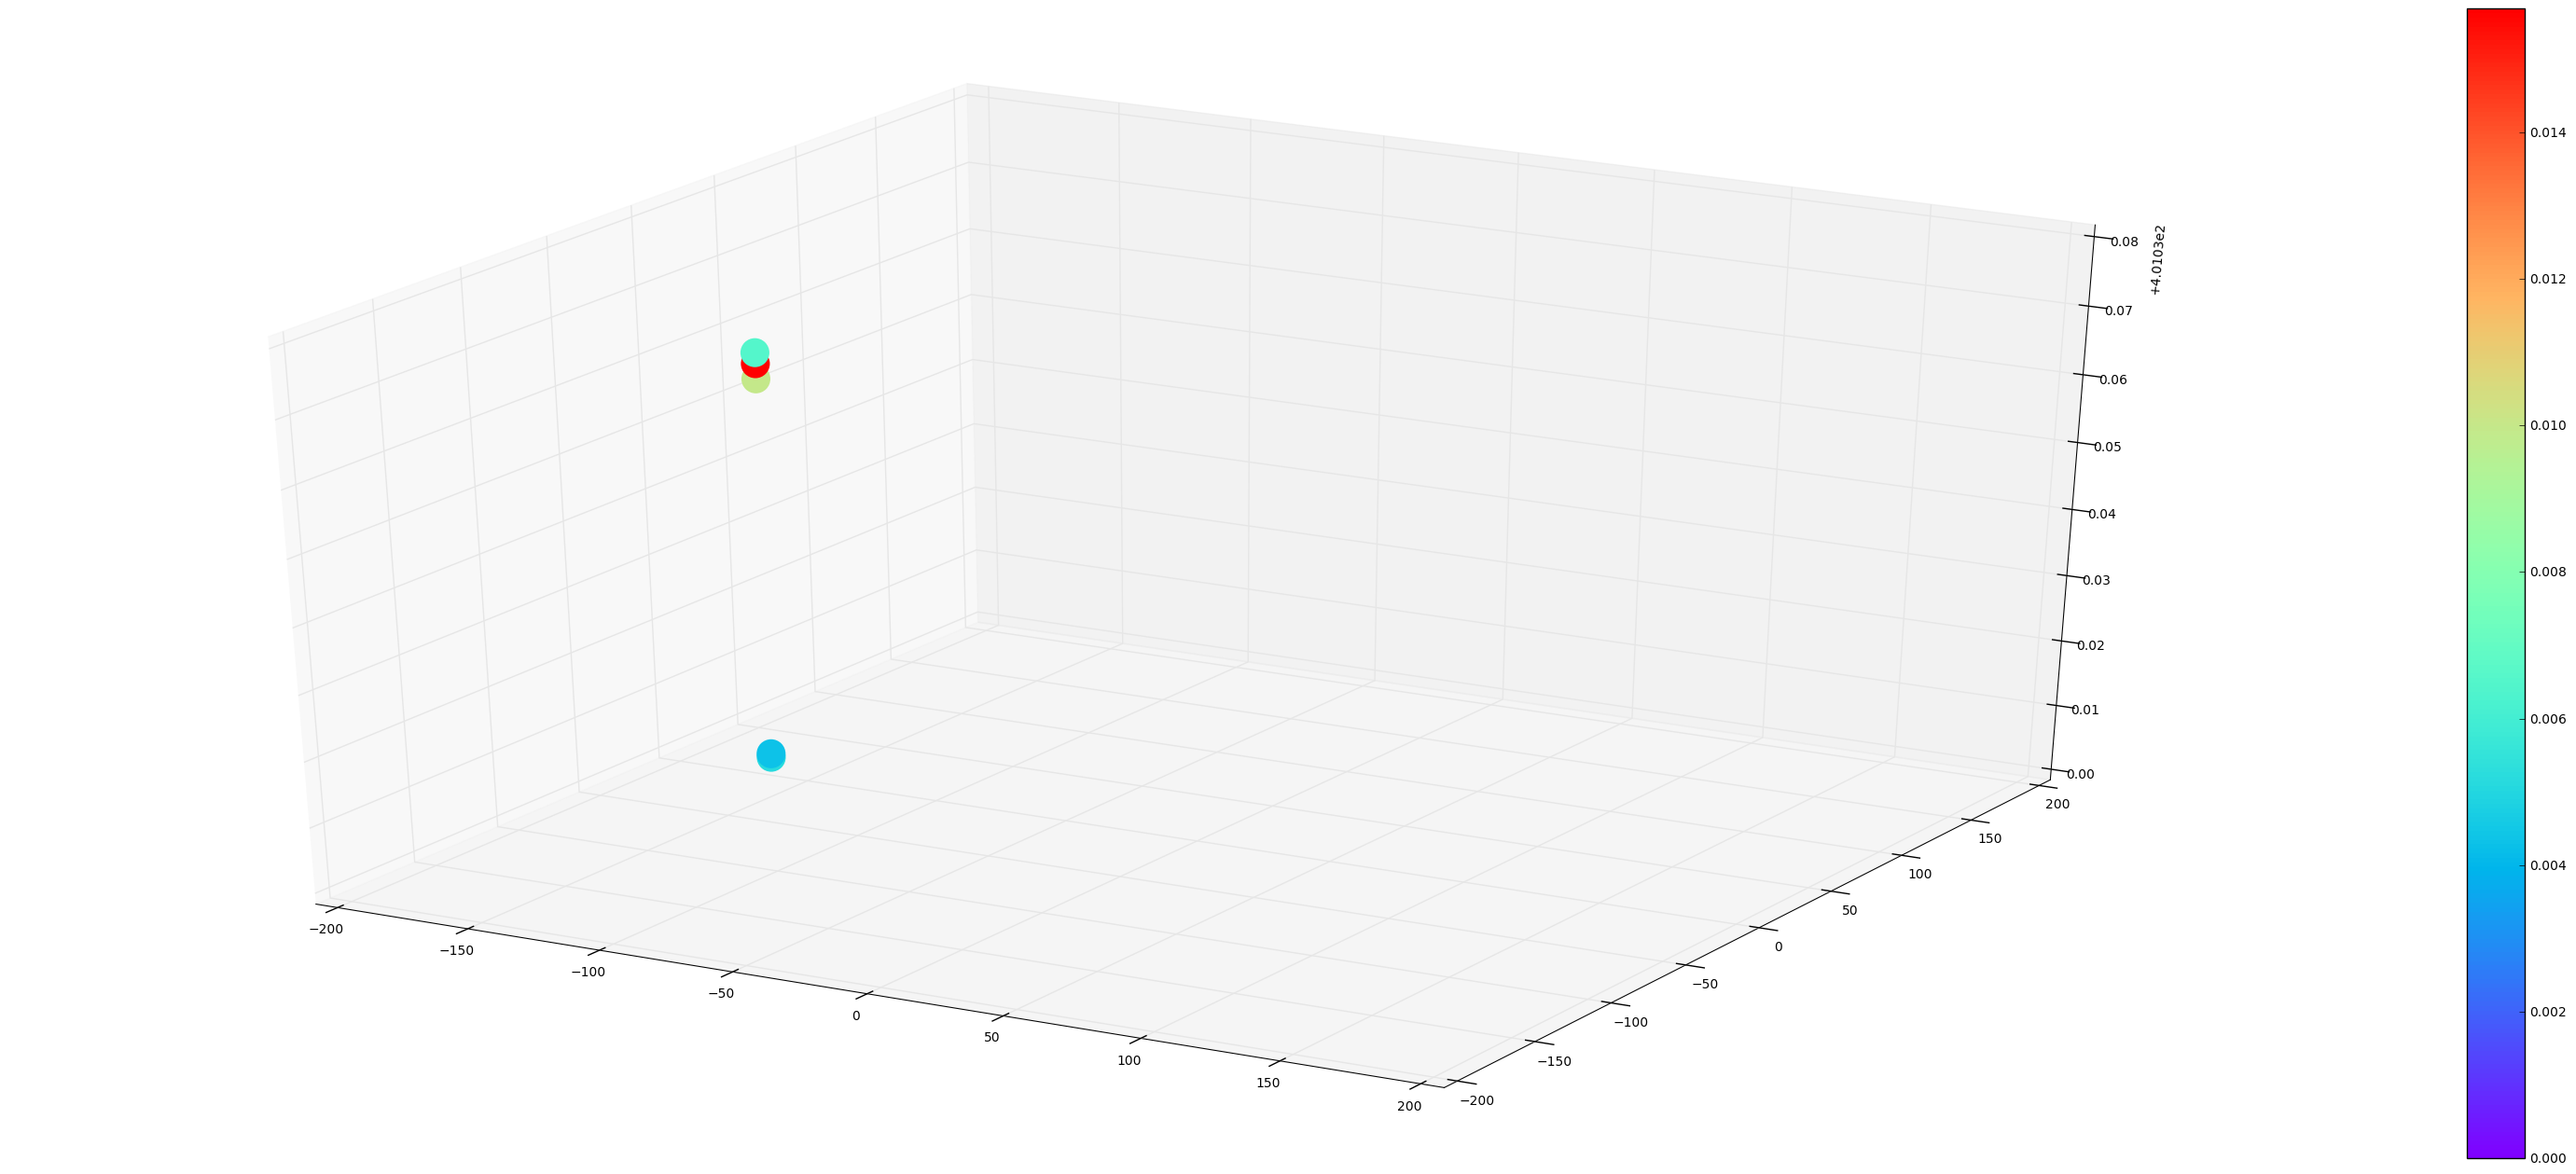

Notice the z (vertical) axis units are very small


In [4]:
event_indx = np.array(tracks[i_start:i_end]['event_indx'],dtype=np.int32)
hit_energy = np.array(tracks[i_start:i_end]['hit_energy'],dtype=np.float32)
hit_pos = np.array(tracks[i_start:i_end]['hit_position'],dtype=np.float32)
particle = np.array(tracks[i_start:i_end]['particle_name'])

# Plot an event
r = rd.sample(event_indx,1)[0]
r = 10
hits = np.where(event_indx == r)[0]

print('DNN label will be the average of these hit positions, weighted by their respective hit energys')
print(hit_pos[hits])

fig = plt.figure()
fig.set_figheight(35.0)
fig.set_figwidth(40.0)
ax = fig.add_subplot(211, projection='3d')
s1=ax.scatter(hit_pos[hits,0], hit_pos[hits,1], hit_pos[hits,2], c=hit_energy[hits], cmap=plt.get_cmap('rainbow'),vmin=0,s=500,edgecolors='None')
s1.set_edgecolors = s1.set_facecolors = lambda *args:None;  # this disables automatic setting of alpha relative of distance to camera
cb1 = plt.colorbar(s1)
ax.set_xlim3d(-200, 200)
ax.set_ylim3d(-200, 200)
#ax.set_zlim3d(-0,500)
plt.grid(True)
plt.show()
print('Notice the z (vertical) axis units are very small')


In [5]:
lbl = np.zeros((np.max(event_indx) + 1, 3), dtype=np.float32)

disc = [] # list of event indices to discard

tot_energy = 0

# total energy for any event should be .041
print('---')
print('Total event energy: ' + str(np.sum(hit_energy[np.where(event_indx == 10)[0]])))
print('---')
print('')
print('...Finding objective truth...')

no_label = []

# Calculate "true" labels for dnn
for i, ev in enumerate(event_indx):
    
    # Discard events that have gammas with more than x energy
    
    # Discard events whose tracks are too far apart 
    
    # Discard events with incorrect total energy 
    
    # Compute average hit_pos, weighted by hit_energy
    lbl[ev] = lbl[ev] + hit_energy[i] * hit_pos[i]
    tot_energy += hit_energy[i]
    
    # Will throw index ev is last event number
    try:
        if event_indx[i + 1] > ev:
            lbl[ev] /= tot_energy
            tot_energy = 0
            if event_indx[i + 1] != ev + 1:
                for i in range(ev + 1, event_indx[i + 1]):
                    no_label.append(i)
    except IndexError: 
        if ev == np.max(event_indx):
            lbl[ev] /= tot_energy
            tot_energy = -99999
            
        # This should not happen, so throw error
        else:  
            print('ERROR: ' + str(event_indx[i + 1]))
print('...Found.')

---
Total event energy: 0.0415433
---

...Finding objective truth...
...Found.


Test that weighted average is being computed correctly

In [6]:
test_evt = rd.sample(event_indx,1)[0]
print(lbl[test_evt])
test_idxs = np.where(event_indx == test_evt)[0]
test_pos = np.array([0,0,0])
for e, pos in zip(hit_energy[test_idxs], hit_pos[test_idxs]):
    test_pos = test_pos + e * pos
test_pos = test_pos / np.sum(hit_energy[test_idxs])
print('=?')
print(test_pos)

[ -71.24407959  173.77903748  105.84603882]
=?
[ -71.24408621  173.77902247  105.84603399]


Now look at the p maps to create SiPM maps

In [7]:
if not gen_all:
    ip_start = pmaps.get_where_list('event == start_event', sort=True)[0]
    print('---PMAP start found...')
    ip_end = pmaps.get_where_list('event == end_event', sort=True)[0]
    print('---PMAP end found...')

    print('---Loading events...')
    event_indx = np.array(pmaps[ip_start:ip_end]['event'], dtype=np.int32)
    amp_list = np.array(pmaps[ip_start:ip_end]['anode'], dtype=np.float32)
    montecarlo.close()
    print('Load Complete.')

---PMAP start found...
---PMAP end found...
---Loading events...
Load Complete.


Create a single SiPM map for each event

In [8]:
f_ids = tb.open_file('ReproducedFull.h5')
s_ids = np.array(f_ids.root.Sensors.XY)
f_ids.close()

# Construct a dictionary that will map sensor id to a x,y coord pair
id_to_coords = {}
for ID, x, y in zip(s_ids[12:, 0], s_ids[12:, 1], s_ids[12:, 2]):
    id_to_coords[np.int32(ID)] = np.array([-x, y])  # -x b/c old IDs!

if not gen_all:
    print('...Populating SiPM maps...')
    # Populate SiPM maps for each event
    maps = np.zeros((np.max(event_indx) + 1, 48, 48), dtype=np.float32)
    for ev, amps in zip(event_indx, amp_list):
        for sipm, amp in enumerate(amps):
            if amp != 0.0:
                ID = sipm % 64 + 1000 * (int(sipm / 64) + 1)
                [i,j] = (id_to_coords[ID] + 235) / 10
                maps[ev, np.int8(i), np.int8(j)] += amp
        #if float(1 + ev) % 1000 == 0:
        #    print(str(float(1 + ev)/(1 + end_event)*100) + '% complete...')
          

if gen_all:
    maps = np.zeros((np.max(event_indx) + 1, 48, 48), dtype=np.float32)
    print('...Populating SiPM maps...')
    
    # Populate SiPM maps for each event
    for row in pmaps.iterrows():
        for sipm, amp in enumerate(row['anode']):
            if amp != 0.0:
                ID = sipm % 64 + 1000 * (int(sipm / 64) + 1)
                [i,j] = (id_to_coords[ID] + 235) / 10
                maps[row['event'], np.int8(i), np.int8(j)] += amp

...Populating SiPM maps...


Delete events that have blank maps or no truth label

In [9]:
print('...Deleting blank SiPM maps...')   
empty_maps = []

for ev, m in enumerate(maps): 
    if np.max(m) == 0.0:
        empty_maps.append(ev)
        

print(empty_maps, no_label)

delete_events = list(set(empty_maps).union(no_label))
print(delete_events)

print(maps.shape,lbl.shape)       
maps = np.delete(maps, delete_events, axis=0)
lbl = np.delete(lbl, delete_events, axis=0)
print(maps.shape,lbl.shape)
print(str(len(delete_events)) + ' events deleted.')

# Check no blank maps
for m in maps:
    if np.max(m) == 0:
        print('BROKEN')
        break

...Deleting blank SiPM maps...
[7056, 9039, 9868] [7056, 9039, 9868]
[7056, 9868, 9039]
(10000, 48, 48) (10000, 3)
(9997, 48, 48) (9997, 3)
3 events deleted.


Plot an event

[-155  -45]
[-145  -55]
[-145  -45]
[-145  -35]
[-145  -25]
[-135  -65]
[-135  -55]
[-135  -45]
[-135  -35]
[-135  -25]
[-125  -55]
[-125  -45]
[-125  -35]
[-115  -45]
[-115  -35]
-135.687 -44.7074


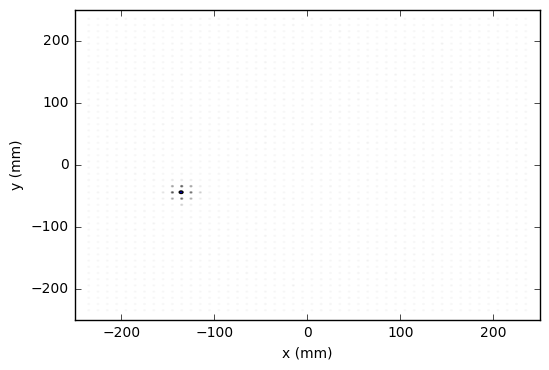

In [13]:
pevt = np.random.randint(np.max(event_indx))
pevt = 10
fig = plt.figure();
ax1 = fig.add_subplot(111);
ax1.axis([-250, 250, -250, 250]);

xarr = maps[pevt]
yarr = lbl[pevt,:2]

# Create circles and plot them according to the probabilities.
probs = (xarr - np.min(xarr))
probs /= np.max(probs)
    
for i in range(48):
    for j in range(48):
        if probs[i,j] > 0.02: print(np.array([i,j])*10 - 235) 
        
        r = Ellipse(xy=(i * 10 - 235, j * 10 - 235), width=2., height=2.);
        r.set_facecolor('0');
        r.set_alpha(0.02 + 0.98 * probs[i, j]);
        ax1.add_artist(r);

# Place a large blue circle for actual EL points.
xpt = yarr[0]
ypt = yarr[1]
mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
mrk.set_facecolor('b');
ax1.add_artist(mrk);
print(xpt,ypt)

# Show the plot.
plt.xlabel("x (mm)");
plt.ylabel("y (mm)");
plt.show()

Save the data!

In [14]:
print('...Saving data...')
if extend_training_set:
    f = tb.open_file('NEW_training_diff_MC_1pt5M.h', 'r+')
    tmaps = f.root.maps
    tcoords = f.root.coords
else:
    f = tb.open_file('NEW_training_diff_MC_1pt5M.h', 'w')
    filters = tb.Filters(complib='blosc', complevel=9, shuffle=False)

    atom    = tb.Atom.from_dtype(maps.dtype)
    tmaps   = f.create_earray(f.root, 'maps',   atom, (0, 48, 48), filters=filters) 

    atom    = tb.Atom.from_dtype(lbl.dtype)
    tcoords = f.create_earray(f.root, 'coords', atom, (0, 3), filters=filters)

for i in range(len(lbl)):
    tmaps.append([maps[i]])
    tcoords.append([lbl[i]])

print('...Save complete.')
print(f)
f.close()

...Saving data...
...Save complete.
NEW_training_diff_MC_1pt5M.h (File) ''
Last modif.: 'Mon Nov 21 18:27:14 2016'
Object Tree: 
/ (RootGroup) ''
/coords (EArray(9997, 3), blosc(9)) ''
/maps (EArray(9997, 48, 48), blosc(9)) ''

